In [17]:
import random

import numpy
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/mith/env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def gauss_noise(mu, sigma):
    """Return a random sample from Gaussian distribution."""
    return numpy.random.normal(loc=mu, scale=sigma)

# Prepare data

Prepare some syntetic data, for example:

$$
y = 1 \cdot [x > 1] = \Theta (x - 1),
$$
where $\Theta$ it is Heaviside step function. 

In [3]:
N = 1000

input_x = sorted([2*random.random() for _ in range(N)])
ideal_y = [1 if i > 1 else 0 for i in input_x]
noisy_y = [1 if i + gauss_noise(0, 0.1) > 1 else 0 for i in input_x]

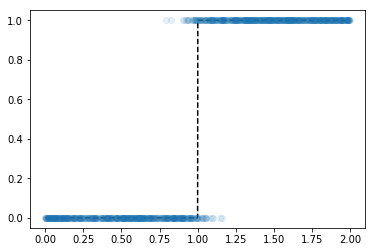

In [4]:
plt.plot(input_x, ideal_y, '--k')
plt.plot(input_x, noisy_y, 'o', alpha=0.1)
plt.show()

In [5]:
training_x = numpy.array(input_x, dtype='float32').reshape((N, -1))
training_y = numpy.array(noisy_y, dtype='float32').reshape((N, -1))

# Neural Network with 2 layers

In [6]:
import tensorflow as tf
import numpy as np
import itertools
import sklearn.metrics as metrics


tf.logging.set_verbosity(0)  # you can set to 1 or 2 in order to see the progress


def net(x_dict):
    """Simple network"""
    x = x_dict['x']
    x = tf.layers.dense(x, 4, activation=tf.nn.elu)
    x = tf.layers.dense(x, 4, activation=tf.nn.elu)
    x = tf.nn.dropout(x, 0.85)
    ops = tf.layers.dense(x, 1, activation=tf.sigmoid)

    return ops


def model_fn(features, labels, mode):
    """Model features."""
    out = net(features)
    pred = out
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        tfe = tf.estimator.EstimatorSpec(
            mode, predictions=pred, export_outputs={
                1: tf.estimator.export.ClassificationOutput(scores=pred, classes=None)})
        return tfe

    labs = labels
    loss_op = tf.losses.sigmoid_cross_entropy(labs, out)
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    train_op = optimizer.minimize(
        loss_op, global_step=tf.train.get_global_step())

    acc_op = tf.metrics.auc(labels=labs, predictions=pred)
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

/home/mith/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
model = tf.estimator.Estimator(model_fn)

train_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': training_x},
    y=training_y,
    batch_size=50, num_epochs=100, shuffle=True)

model.train(train_fn)

# Predict

In order to test our predictions, let's prepare test imput both, within and outside the training region.

In [8]:
N = 1000

test_input_x = sorted([4*random.random()-1 for _ in range(N)])
test_ideal_y = [1 if i > 1 else 0 for i in input_x]
test_noisy_y = [1 if i + gauss_noise(0, 0.1) > 1 else 0 for i in input_x]

In [9]:
testing_x = numpy.array(test_input_x, dtype='float32').reshape((N, -1))
testing_y = numpy.array(test_noisy_y, dtype='float32').reshape((N, -1))

In [10]:
# we predict 100 times; each time we predict we use droput
# (note, normally dropout is used only during training.
#  however here, in order to obtain uncertanity, we use
#  dropout during predictions as well)

test_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': testing_x},
    y=testing_y, num_epochs=100, shuffle=False)

preds = model.predict(test_fn)
preds = numpy.array([i for i in preds]).reshape((100, -1))

In [11]:
# calculate averate results and standard deviation
average = [numpy.mean(i) for i in preds.T]
deviation = [numpy.std(i) for i in preds.T]

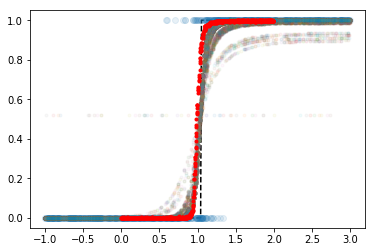

In [12]:
# plot resuls

plt.plot(test_input_x, test_ideal_y, '--k')
plt.plot(test_input_x, test_noisy_y, 'o', alpha=0.1)

for i in range(100):
    plt.plot(test_input_x, preds[i], '.', alpha=0.05)
    
plt.plot(input_x, average, '.r')

plt.show()